This is a skipgram implementation based on a test dataset. This will be tested on the main dataset later

In [1]:
import numpy as np
import tensorflow as tf
import collections
import pandas as pd

In [2]:
#reading pickled data
f=open('./data/text8','r',encoding="utf8")
txt=f.read()
f.close()


In [3]:
txt=txt.lower()

In [4]:
n_words=50000
words=txt.split()
count=collections.Counter(words).most_common(n_words - 1)
count.insert(0,('rare_word',-1))
i=0
word_dict=dict()
for word,num in count:
    word_dict[word]=i
    i+=1

words_num_list=list()
rare_word_count=0
for word in words:
    ind=word_dict.get(word,0)
    words_num_list.append(ind)
    if ind==0:
        rare_word_count+=1
count[0]=('rare_word',rare_word_count)



In [5]:
import random
global_counter=0
def generate_batch_seq(batch_size,skip_window,num_skip):
    global global_counter
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    training_labels = np.ndarray(shape=(batch_size,1), dtype=np.int32)    
    window_span=skip_window * 2 + 1
    for i in range(batch_size//num_skip):
        if global_counter+window_span>len(words_num_list):
            global_counter=0
        word_window=words_num_list[global_counter:global_counter+window_span]
        context_indices_in_window=[w for w in range(window_span) if w!=skip_window]
        selected_indices=random.sample(context_indices_in_window,num_skip)
        for j,selected_index in enumerate(selected_indices):
            context_word=word_window[selected_index]
            center_word=word_window[skip_window]
            batch[i*num_skip+j]=context_word
            training_labels[i*num_skip+j]=center_word
        global_counter +=1
    return batch,training_labels

In [6]:
batch_size = 128
embedding_size = 300  # Dimension of the embedding vector.
skip_window = 2  # How many words to consider left and right.
num_skip = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

graph=tf.Graph()
with graph.as_default():
    inputs = tf.placeholder(tf.int32, shape=[batch_size])
    labels = tf.placeholder(tf.int32, shape=[batch_size,1])
    embeddings = tf.Variable(tf.random_uniform([n_words, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, inputs)
    nce_loss_weights = tf.Variable(tf.truncated_normal([n_words, embedding_size],stddev=1.0 / np.sqrt(embedding_size)))
    nce_loss_biases = tf.Variable(tf.zeros([n_words]))
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_loss_weights,biases=nce_loss_biases,labels=labels,inputs=embed,
                                         num_sampled=num_sampled,num_classes=n_words))
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    init = tf.global_variables_initializer()
steps=100000
with tf.Session(graph=graph) as session:
    init.run()
    print('Initialized')

    average_loss = 0
    for step in range(steps):
        batch_inputs, batch_labels = generate_batch_seq(batch_size, skip_window,num_skip)
        feed_dict = {inputs: batch_inputs, labels: batch_labels}
        _, loss_val = session.run(
        [optimizer, loss],
        feed_dict=feed_dict)
        if step%1000==0:
            print(step,'loss=',loss_val)
    final_embeddings=normalized_embeddings.eval()

Initialized
0 loss= 265.785
1000 loss= 69.4861
2000 loss= 81.398
3000 loss= 52.436
4000 loss= 56.395
5000 loss= 32.1257
6000 loss= 52.4291
7000 loss= 14.5577
8000 loss= 27.6779
9000 loss= 19.3889
10000 loss= 22.9364
11000 loss= 16.3077
12000 loss= 23.7414
13000 loss= 16.7032
14000 loss= 14.3961
15000 loss= 14.5792
16000 loss= 8.08966
17000 loss= 15.9414
18000 loss= 7.37412
19000 loss= 14.0432
20000 loss= 5.49837
21000 loss= 4.12219
22000 loss= 9.88841
23000 loss= 7.44833
24000 loss= 5.18735
25000 loss= 5.66951
26000 loss= 13.2576
27000 loss= 8.47036
28000 loss= 6.06399
29000 loss= 9.53407
30000 loss= 13.7701
31000 loss= 8.00479
32000 loss= 6.64297
33000 loss= 4.57207
34000 loss= 4.9224
35000 loss= 5.23428
36000 loss= 8.05042
37000 loss= 4.79549
38000 loss= 4.46552
39000 loss= 4.93587
40000 loss= 4.72782
41000 loss= 4.685
42000 loss= 8.29446
43000 loss= 4.62271
44000 loss= 5.32721
45000 loss= 4.89884
46000 loss= 4.82452
47000 loss= 4.38731
48000 loss= 4.99972
49000 loss= 5.75327
50000 l

In [40]:
a=final_embeddings[word_dict['seven']]
a

array([ 0.14040966, -0.02776616,  0.10178349, -0.09753264, -0.10452515,
        0.05184804,  0.02099159,  0.06259413, -0.03310964,  0.09948918,
        0.08611192,  0.0628792 , -0.03434261, -0.0701175 , -0.03961278,
        0.1638768 , -0.04883439, -0.03221637, -0.03874353, -0.09536362,
        0.0793755 ,  0.16915622,  0.00979639, -0.03772007,  0.03114106,
        0.03779602, -0.08399805,  0.11200145,  0.09478668, -0.00299606,
        0.04460226,  0.07159378,  0.06221491,  0.03377119, -0.15642394,
       -0.07752319, -0.06171929, -0.13492399,  0.0758604 , -0.11166994,
       -0.22871402,  0.02105925, -0.08079995,  0.04700314, -0.02488706,
        0.01620119, -0.05679198,  0.06229544,  0.06413181, -0.05283024,
       -0.2004569 ,  0.17969528,  0.00177085,  0.10650302,  0.19002354,
        0.13254014, -0.04470259, -0.06295761, -0.06446208,  0.116992  ,
       -0.02618374,  0.03380758, -0.11249728,  0.12750009, -0.02563464,
        0.07074245,  0.00142915,  0.05273004, -0.0782823 ,  0.05

In [14]:
b=np.array([  9.50842574e-02,   1.25944689e-01,  -2.94151772e-02,
        -1.29352421e-01,   1.12925820e-01,  -7.72998258e-02,
        -8.38127434e-02,  -3.67071200e-03,  -5.24396189e-02,
         7.83187598e-02,  -3.54035236e-02,  -3.50664295e-02,
        -9.35276970e-02,   9.32115838e-02,  -2.83335652e-02,
         1.88707188e-02,   6.93118274e-02,   8.57837424e-02,
        -5.92109077e-02,   4.13407572e-02,   9.95713845e-02,
        -1.38840592e-02,   9.67866555e-02,  -1.89571470e-01,
         5.12465350e-02,   3.32152136e-02,   1.24238797e-01,
        -4.96991836e-02,  -1.57316439e-02,   1.00629278e-01,
         9.19771567e-02,  -9.32746753e-02,   1.59674062e-04,
         1.63246375e-02,  -7.07137510e-02,  -8.90430994e-04,
        -2.33383325e-04,   1.47638410e-01,  -7.80871660e-02,
        -1.41034788e-02,  -2.19275560e-02,  -5.60291708e-02,
         1.16973951e-01,  -5.35482690e-02,   2.50558648e-03,
         2.38607787e-02,  -1.01594575e-01,   4.51994985e-02,
         3.33437696e-02,  -4.87019457e-02,  -8.69866088e-02,
         2.19188072e-02,  -2.20010243e-02,  -1.78737804e-01,
        -5.08251674e-02,  -3.54889221e-02,  -7.29371533e-02,
         1.05053335e-01,  -1.75403021e-02,  -7.98022375e-02,
        -7.23914877e-02,  -7.18780681e-02,  -5.53422049e-02,
         9.31229591e-02,  -2.57390346e-02,   1.34103179e-01,
        -3.96767408e-02,  -4.10885215e-02,   1.62513226e-01,
        -1.81317881e-01,  -4.42858152e-02,   2.43899394e-02,
         3.39263980e-03,  -4.64201011e-02,   3.85493366e-03,
        -4.04712297e-02,  -1.37735009e-01,   1.13709271e-01,
         1.03873849e-01,   1.54105248e-02,  -6.01210408e-02,
         1.57578051e-01,   1.65407062e-01,  -1.56898797e-01,
         4.72244620e-02,  -6.29562065e-02,   1.64155006e-01,
        -7.41022229e-02,  -9.93008260e-03,   4.47183400e-02,
         1.47464693e-01,  -5.27518205e-02,   2.28188056e-02,
        -4.88798954e-02,   1.57316059e-01,  -2.36172583e-02,
         2.58812886e-02,   1.41996324e-01,   9.77174030e-04,
         7.26625100e-02,   7.35295936e-02,   4.19195332e-02,
        -1.61372066e-01,   1.37061188e-02,   9.16308016e-02,
        -3.00270095e-02,  -1.55448437e-01,  -1.17844760e-01,
         1.66241959e-01,   3.70653123e-02,   1.87501144e-02,
         1.30324319e-01,  -7.47253224e-02,   1.21102758e-01,
         2.24553362e-01,  -1.08243667e-01,   2.24076360e-02,
        -4.12904285e-03,   5.14800474e-02,  -7.62162060e-02,
         2.00872228e-01,   1.28470995e-02,   3.81768942e-02,
        -6.47891238e-02,  -9.80087183e-03,  -5.82503304e-02,
         5.68843894e-02,   1.36023343e-01], dtype=np.float32)


In [41]:
a.dot(b)/(np.sqrt(np.sum((a*b)**2)))

-1.5198957

In [8]:
reverse_dict={v: k for k, v in word_dict.items()}

In [9]:
# pylint: disable=g-import-not-at-top
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

tsne = TSNE(
  perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dict[i] for i in range(plot_only)]


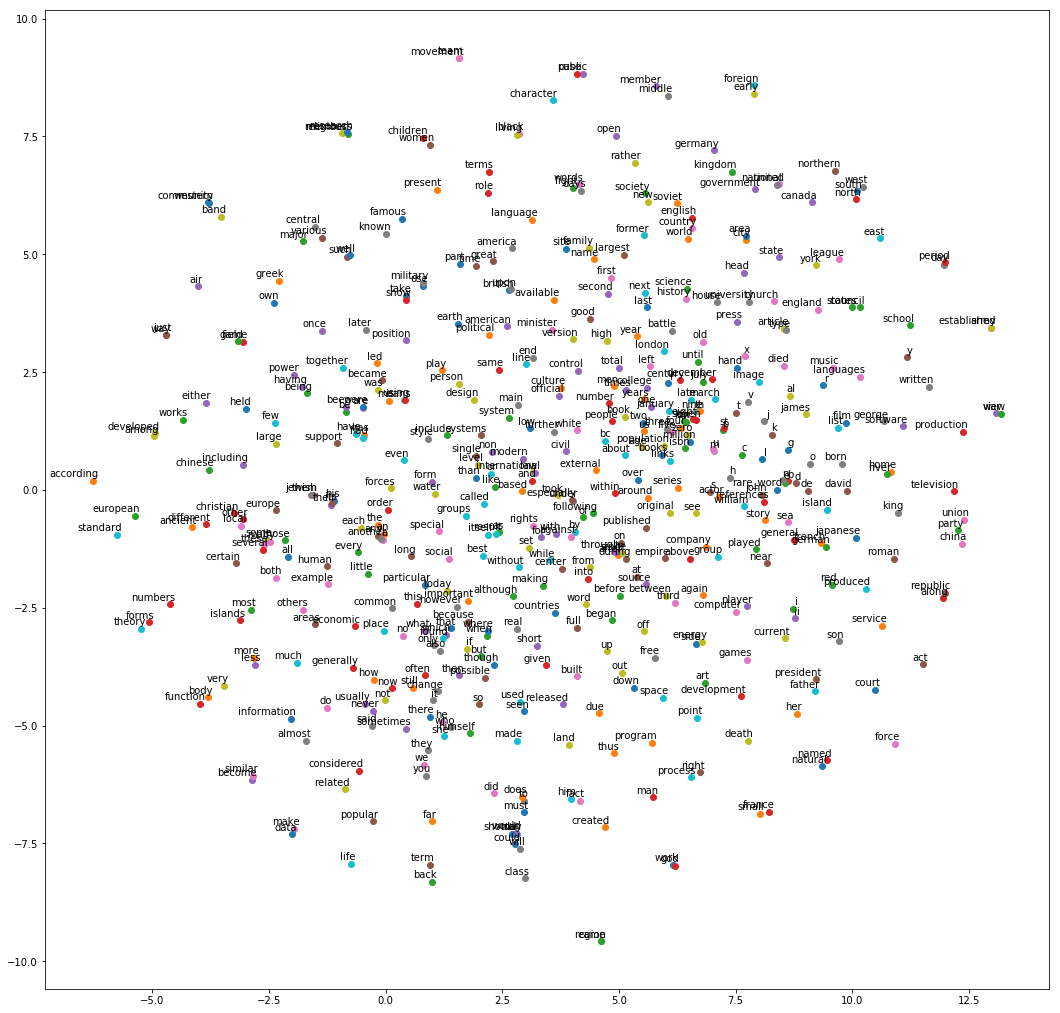

In [10]:
import os
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

    plt.savefig(filename)
plot_with_labels(low_dim_embs, labels, 'tsne.png')

In [13]:
np.savez('./data/word2vec_simple.npz',final_embeddings,word_dict,reverse_dict)